###  Why this project
Objective: analyze coffee shop sales data to extract actionable insights for operations and marketing.
Key questions:
- Which coffee types sell most and when (hour/day/month)?
- How does payment method (`cash_type`) affect average transaction value?
- Are there strong correlations between time-of-day, day-of-week, and revenue?
- Data-prep tasks: cleaning, feature engineering, encoding for modeling, and handling skewed numeric features.
- Identify peak hours & best-selling items for staffing and inventory.
- Determine if promotion timing (hour/day) can increase revenue.



### Import Libraries


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (8,4)
sns.set(style="whitegrid")


### Loading Dataset & Exploring the Data


In [2]:
FILE = "Coffe_sales.csv"
df = pd.read_csv(FILE)

print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
display(df.head(8))
display(df.info())
display(df.describe(include='all').T)


Shape: (3547, 11)

Columns:
 ['hour_of_day', 'cash_type', 'money', 'coffee_name', 'Time_of_Day', 'Weekday', 'Month_name', 'Weekdaysort', 'Monthsort', 'Date', 'Time']


,hour_of_day,cash_type,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,Date,Time
0,10,card,38.7,Latte,Morning,Fri,Mar,5,3,2024-03-01,10:15:50.520000
1,12,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:19:22.539000
2,12,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:20:18.089000
3,13,card,28.9,Americano,Afternoon,Fri,Mar,5,3,2024-03-01,13:46:33.006000
4,13,card,38.7,Latte,Afternoon,Fri,Mar,5,3,2024-03-01,13:48:14.626000
5,15,card,33.8,Americano with Milk,Afternoon,Fri,Mar,5,3,2024-03-01,15:39:47.726000
6,16,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,16:19:02.756000
7,18,card,33.8,Americano with Milk,Night,Fri,Mar,5,3,2024-03-01,18:39:03.580000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3547 entries, 0 to 3546
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hour_of_day  3547 non-null   int64  
 1   cash_type    3547 non-null   object 
 2   money        3547 non-null   float64
 3   coffee_name  3547 non-null   object 
 4   Time_of_Day  3547 non-null   object 
 5   Weekday      3547 non-null   object 
 6   Month_name   3547 non-null   object 
 7   Weekdaysort  3547 non-null   int64  
 8   Monthsort    3547 non-null   int64  
 9   Date         3547 non-null   object 
 10  Time         3547 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 304.9+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
hour_of_day,3547.0,NaN,NaN,NaN,14.185791,4.23401,6.0,10.0,14.0,18.0,22.0
cash_type,3547,1,card,3547,NaN,NaN,NaN,NaN,NaN,NaN,NaN
money,3547.0,NaN,NaN,NaN,31.645216,4.877754,18.12,27.92,32.82,35.76,38.7
coffee_name,3547,8,Americano with Milk,809,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time_of_Day,3547,3,Afternoon,1205,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weekday,3547,7,Tue,572,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Month_name,3547,12,Mar,494,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weekdaysort,3547.0,NaN,NaN,NaN,3.845785,1.971501,1.0,2.0,4.0,6.0,7.0
Monthsort,3547.0,NaN,NaN,NaN,6.453905,3.500754,1.0,3.0,7.0,10.0,12.0
Date,3547,381,2024-10-11,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Cleaning 

In [3]:
df.columns = [c.strip().replace(" ", "_").replace("...", "_") for c in df.columns]

if 'Date' in df.columns:
    try:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    except Exception:
        df['Date'] = pd.to_datetime(df['Date'].astype(str), errors='coerce')

if 'Time' in df.columns:
    try:
        df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce').dt.time
    except Exception:
        df['Time'] = df['Time'].astype(str)

if 'Date' in df.columns and 'Time' in df.columns and pd.api.types.is_datetime64_any_dtype(df['Date']):
    try:
        df['datetime'] = pd.to_datetime(df['Date'].dt.strftime('%Y-%m-%d') + ' ' + df['Time'].astype(str), errors='coerce')
    except Exception:
        df['datetime'] = df['Date']

if 'datetime' in df.columns and pd.api.types.is_datetime64_any_dtype(df['datetime']):
    df['hour'] = df['datetime'].dt.hour
    df['weekday'] = df['datetime'].dt.day_name()
    df['is_weekend'] = df['weekday'].isin(['Saturday','Sunday'])
else:
    if 'hour_of_day' in df.columns:
        df['hour'] = df['hour_of_day']


### Missing Values & Duplicates

In [4]:

missing = df.isnull().sum().sort_values(ascending=False)
print("Missing values per column:\n", missing[missing>0])

dupes = df.duplicated().sum()
print("Duplicate rows:", dupes)



Missing values per column:
 hour        3539
weekday     3539
Time        3539
datetime    3539
dtype: int64
Duplicate rows: 609


### Data Types & Basic Stats

In [5]:
numerics = df.select_dtypes(include=[np.number]).columns.tolist()
objects = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric columns:", numerics)
print("Object columns:", objects)

num_desc = df[numerics].describe().T
num_desc['skew'] = df[numerics].skew()
num_desc['kurtosis'] = df[numerics].kurtosis()
display(num_desc)

for col in objects:
    print(f"\nTop values for {col}:")
    display(df[col].value_counts().head(10))


Numeric columns: ['hour_of_day', 'money', 'Weekdaysort', 'Monthsort', 'hour']
Object columns: ['cash_type', 'coffee_name', 'Time_of_Day', 'Weekday', 'Month_name', 'Time', 'weekday']


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
hour_of_day,3547.0,14.185791,4.234010,6.00,10.00,14.00,18.00,22.0,0.121513,-1.126781
money,3547.0,31.645216,4.877754,18.12,27.92,32.82,35.76,38.7,-0.544507,-0.671208
Weekdaysort,3547.0,3.845785,1.971501,1.00,2.00,4.00,6.00,7.0,0.082132,-1.224040
Monthsort,3547.0,6.453905,3.500754,1.00,3.00,7.00,10.00,12.0,0.004314,-1.383442
hour,8.0,17.125000,4.323937,11.00,14.75,18.00,21.00,21.0,-0.622244,-1.405506



Top values for cash_type:


cash_type
card    3547
Name: count, dtype: int64


Top values for coffee_name:


coffee_name
Americano with Milk    809
Latte                  757
Americano              564
Cappuccino             486
Cortado                287
Hot Chocolate          276
Cocoa                  239
Espresso               129
Name: count, dtype: int64


Top values for Time_of_Day:


Time_of_Day
Afternoon    1205
Morning      1181
Night        1161
Name: count, dtype: int64


Top values for Weekday:


Weekday
Tue    572
Mon    544
Fri    532
Thu    510
Wed    500
Sat    470
Sun    419
Name: count, dtype: int64


Top values for Month_name:


Month_name
Mar    494
Oct    426
Feb    423
Sep    344
Aug    272
Dec    259
Nov    259
May    241
Jul    237
Jun    223
Name: count, dtype: int64


Top values for Time:


Time
21:23:53    1
16:11:48    1
21:26:26    1
11:21:22    1
11:42:20    1
21:25:32    1
20:15:20    1
16:18:44    1
Name: count, dtype: int64


Top values for weekday:


weekday
Wednesday    2
Tuesday      2
Thursday     1
Saturday     1
Friday       1
Monday       1
Name: count, dtype: int64

### Insights :

Which numeric columns are highly skewed (skew > 1 or < -1).

If any categorical column has many unique categories (high cardinality).

Example insight: "money (transaction amount) skew=2.5 (right-skewed) — consider log or power transform."

### Classification into categories (Nominal,Ordinal,Categorical,Numeric)

In [6]:
ordinal_keywords = ['rating','score','rank','level','size']
nominal = objects[:]  
ordinal = []
categorical_numeric = []
continuous = []

for c in df.columns:
    if c in nominal:
        continue
    if pd.api.types.is_numeric_dtype(df[c]):
        nunique = df[c].nunique(dropna=True)
        if any(k in c.lower() for k in ordinal_keywords):
            ordinal.append(c)
        elif nunique <= 10:
            categorical_numeric.append(c)
        else:
            continuous.append(c)
    else:
        if np.issubdtype(df[c].dtype, np.datetime64):
            continuous.append(c)
        else:
            nominal.append(c)

print("Nominal:", nominal)
print("Ordinal:", ordinal)
print("Categorical (numeric small cardinality):", categorical_numeric)
print("Continuous numeric:", continuous)


Nominal: ['cash_type', 'coffee_name', 'Time_of_Day', 'Weekday', 'Month_name', 'Time', 'weekday']
Ordinal: []
Categorical (numeric small cardinality): ['Weekdaysort', 'hour', 'is_weekend']
Continuous numeric: ['hour_of_day', 'money', 'Monthsort', 'Date', 'datetime']


### Insights :
Treat Month_name as nominal or ordinal? If you want month ordering for seasonality, convert to categorical with explicit order."

### EDA Plots (counts, hourly patterns, top items)

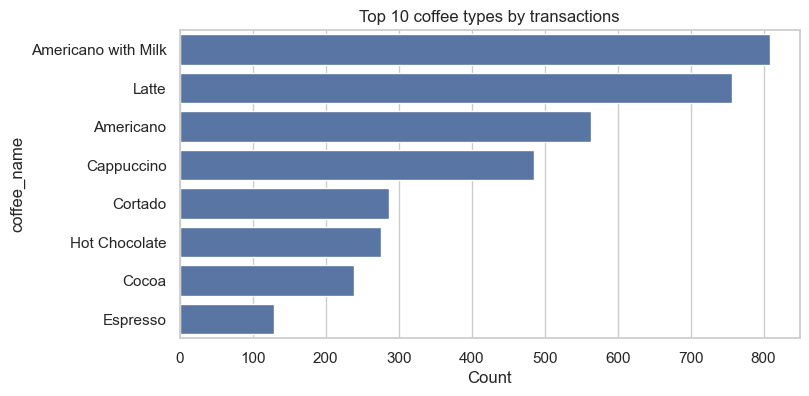

Insight: top coffee types: ['Americano with Milk', 'Latte', 'Americano', 'Cappuccino', 'Cortado', 'Hot Chocolate', 'Cocoa', 'Espresso']


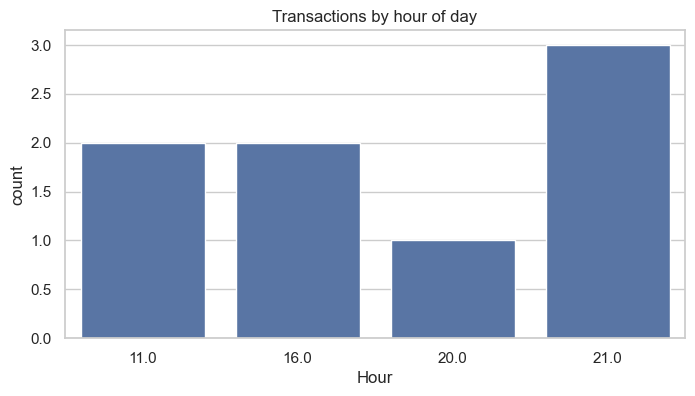

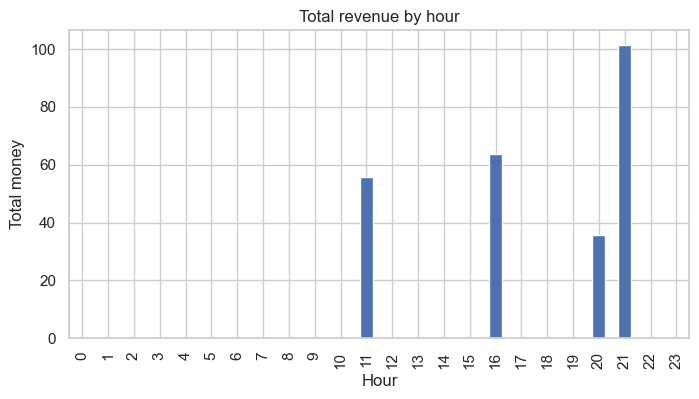

hour
0       0.00
1       0.00
2       0.00
3       0.00
4       0.00
5       0.00
6       0.00
7       0.00
8       0.00
9       0.00
10      0.00
11     55.84
12      0.00
13      0.00
14      0.00
15      0.00
16     63.68
17      0.00
18      0.00
19      0.00
20     35.76
21    101.40
22      0.00
23      0.00
Name: money, dtype: float64

In [7]:
if 'coffee_name' in df.columns:
    top_coffees = df['coffee_name'].value_counts().nlargest(10)
    plt.figure()
    sns.barplot(y=top_coffees.index, x=top_coffees.values)
    plt.title("Top 10 coffee types by transactions")
    plt.xlabel("Count")
    plt.show()
    print("Insight: top coffee types:", top_coffees.index.tolist())

if 'hour' in df.columns:
    plt.figure()
    sns.countplot(data=df, x='hour', order=sorted(df['hour'].dropna().unique()))
    plt.title("Transactions by hour of day")
    plt.xlabel("Hour")
    plt.show()
if 'money' in df.columns and 'hour' in df.columns:
    rev_by_hour = df.groupby('hour')['money'].sum().reindex(range(0,24), fill_value=0)
    plt.figure()
    rev_by_hour.plot(kind='bar')
    plt.title("Total revenue by hour")
    plt.xlabel("Hour")
    plt.ylabel("Total money")
    plt.show()
    display(rev_by_hour.head(24))


### Insights :

"Peak transaction hours: 8–10 and 16–18, matching commute/coffee-break times — consider staffing."

"Top 3 coffee types account for X% of transactions — good candidates for promotions."

### Grouped analysis: payment type, weekday, month

,count,mean,median,sum
cash_type,,,,
card,3547,31.645216,32.82,112245.58


Insight: Compare average transaction sizes by payment method.


weekday
Monday       35.76
Tuesday      63.68
Wednesday    70.54
Thursday     27.92
Friday       35.76
Saturday     23.02
Sunday         NaN
Name: money, dtype: float64

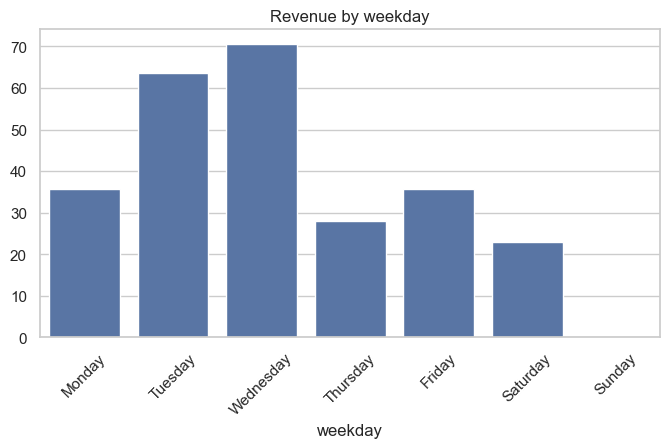

In [8]:
if 'cash_type' in df.columns and 'money' in df.columns:
    mt = df.groupby('cash_type')['money'].agg(['count','mean','median','sum']).sort_values('count', ascending=False)
    display(mt)
    print("Insight: Compare average transaction sizes by payment method.")


if 'weekday' in df.columns and 'money' in df.columns:
    rev_wk = df.groupby('weekday')['money'].sum().reindex(
        ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    )
    display(rev_wk)
    sns.barplot(x=rev_wk.index, y=rev_wk.values)
    plt.xticks(rotation=45)
    plt.title("Revenue by weekday")
    plt.show()


### Insights :

"If cash_type='card' has higher average money than cash, consider promoting card payments."

"Weekdays X and Y have lower revenue — consider weekday promotions."

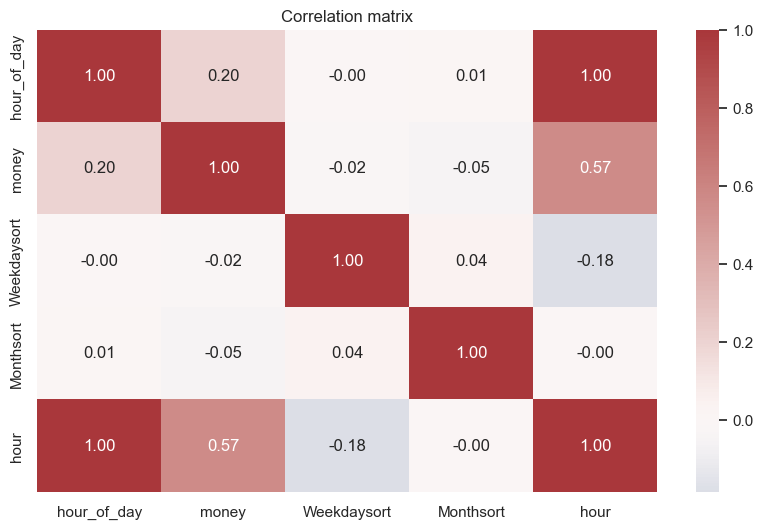

Strong correlations (|r| >= 0.7): [('hour_of_day', 'hour', np.float64(1.0))]


In [9]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) >= 2:
    corr = df[num_cols].corr()
    plt.figure(figsize=(10,6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='vlag', center=0)
    plt.title("Correlation matrix")
    plt.show()
    strong_pairs = []
    for i in range(len(num_cols)):
        for j in range(i+1, len(num_cols)):
            v = corr.iloc[i,j]
            if abs(v) >= 0.7:
                strong_pairs.append((num_cols[i], num_cols[j], v))
    print("Strong correlations (|r| >= 0.7):", strong_pairs)


### Insights :

"If money correlates strongly with hour (>0.7) that's unusual — inspect data for grouped values or errors."

### Outlier Analysis (IQR)

In [10]:
outlier_summary = {}
for c in num_cols:
    col = df[c].dropna()
    q1 = col.quantile(0.25); q3 = col.quantile(0.75); iqr = q3 - q1
    lower = q1 - 1.5*iqr; upper = q3 + 1.5*iqr
    outliers = df[(df[c] < lower) | (df[c] > upper)][c]
    outlier_summary[c] = {'count': len(outliers), 'pct': len(outliers)/len(col)}
outlier_df = pd.DataFrame(outlier_summary).T.sort_values('pct', ascending=False)
display(outlier_df)



,count,pct
hour_of_day,0.0,0.0
money,0.0,0.0
Weekdaysort,0.0,0.0
Monthsort,0.0,0.0
hour,0.0,0.0


### Insights :

"Column money has 3.2% outliers on the high side — these are likely large orders or data errors."

### One - Hot Encoding

In [11]:
nominal_cols = df.select_dtypes(include=['object','category']).columns.tolist()
print("Nominal columns to encode:", nominal_cols)

def ohe_df(df, cols, drop_first=False, thresh=None):
    
    to_encode = []
    for c in cols:
        if thresh and df[c].nunique() > thresh:
            print(f"Skipping {c} due to high cardinality ({df[c].nunique()})")
        else:
            to_encode.append(c)
    return pd.get_dummies(df, columns=to_encode, drop_first=drop_first, dummy_na=False)

df_ohe = ohe_df(df, nominal_cols, drop_first=False, thresh=50)  
print("Shape after OHE:", df_ohe.shape)
display(df_ohe.head())


Nominal columns to encode: ['cash_type', 'coffee_name', 'Time_of_Day', 'Weekday', 'Month_name', 'Time', 'weekday']
Shape after OHE: (3547, 53)


,hour_of_day,money,Weekdaysort,Monthsort,Date,datetime,hour,is_weekend,cash_type_card,coffee_name_Americano,...,Time_20:15:20,Time_21:23:53,Time_21:25:32,Time_21:26:26,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,10,38.7,5,3,2024-03-01,NaT,NaN,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,12,38.7,5,3,2024-03-01,NaT,NaN,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,12,38.7,5,3,2024-03-01,NaT,NaN,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,13,28.9,5,3,2024-03-01,NaT,NaN,False,True,True,...,False,False,False,False,False,False,False,False,False,False
4,13,38.7,5,3,2024-03-01,NaT,NaN,False,True,False,...,False,False,False,False,False,False,False,False,False,False


### Insights :

"One-hot encoding can expand columns significantly; if coffee_name has 200 unique values consider target/frequency encoding instead."

Example insight: "After OHE, dataset increased from 11 to 45 features — good for tree models but may hurt linear models."

### Power Transform & Log Transform

In [12]:
from sklearn.preprocessing import PowerTransformer
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

stats_before = pd.DataFrame({
    'skew': df[num_cols].skew(),
    'kurtosis': df[num_cols].kurtosis()
}).sort_values('skew', key=abs, ascending=False)
display(stats_before)


pt = PowerTransformer(method='yeo-johnson', standardize=False)
df_power = df.copy()
df_power[num_cols] = pt.fit_transform(df_power[num_cols].fillna(df_power[num_cols].median()))

stats_after_power = pd.DataFrame({
    'skew_after_power': df_power[num_cols].skew(),
    'kurtosis_after_power': df_power[num_cols].kurtosis()
}).sort_values('skew_after_power', key=abs, ascending=False)
display(stats_after_power)


df_log = df.copy()
log_cols = [c for c in num_cols if (df[c].min(skipna=True) >= 0)]
for c in log_cols:
    df_log[c] = np.log1p(df_log[c].fillna(0))

stats_after_log = pd.DataFrame({
    'skew_after_log': df_log[log_cols].skew(),
    'kurtosis_after_log': df_log[log_cols].kurtosis()
})
display(stats_after_log)


df_power.to_csv('Coffe_sales_power_transformed.csv', index=False)
df_log.to_csv('Coffe_sales_log_transformed.csv', index=False)
df_ohe.to_csv('Coffe_sales_ohe.csv', index=False)
print("Saved transformed files ")


,skew,kurtosis
hour,-0.622244,-1.405506
money,-0.544507,-0.671208
hour_of_day,0.121513,-1.126781
Weekdaysort,0.082132,-1.224040
Monthsort,0.004314,-1.383442


,skew_after_power,kurtosis_after_power
hour,7.871563,560.637132
money,-0.174942,-1.149026
Monthsort,-0.168406,-1.337550
Weekdaysort,-0.115749,-1.209043
hour_of_day,-0.056999,-1.121544


,skew_after_log,kurtosis_after_log
hour_of_day,-0.260391,-1.015186
money,-0.828772,0.029593
Weekdaysort,-0.439760,-1.018638
Monthsort,-0.543267,-0.936369
hour,21.212121,450.990605


Saved transformed files 


### Insights :

Compare skew before vs. after:

If skew magnitude drops (e.g., 2.5 → 0.2) transform succeeded.

If not, consider different transforms or winsorization.

Example: "After Yeo-Johnson, money skew reduced from 2.5 to 0.3 → distribution nearly symmetric."